# Triplet Loss

With Contrastive Loss, our model was struggling to push apart embeddings far enough to allow for reliable differentiation of hard pairings.

Triplet Loss aims to fix this. Instead of comparing the reference (anchor) image to a single positive or negative sample, the anchor image is always compared against a positive **and** negative sample.

Let's use TensorFlow's `TripletSemiHardLoss` to explore triplet loss.

For implementations of Triplet Loss the Siamese Network Architecture is usually interpreted a bit more loosely:
Instead of defining a model with multiple inputs, shared weights and a distance layer, a model with a single input is used and the distances are computed and compared for the model outputs within a whole batch.

In [1]:
from core.dataset import DGSAlphabet

TEST_LABELS = ['u', 'v', 'w', 'x', 'y']

# Import the dataset
dataset = DGSAlphabet()
categorical_dataset = dataset.load_categorical_numeric(
    exclusive_test_labels=TEST_LABELS
)
x_train = categorical_dataset.x_train
y_train = categorical_dataset.y_train
x_test = categorical_dataset.x_test
y_test = categorical_dataset.y_test
label_map = categorical_dataset.label_map

We'll instantiate our encoder as always, but append a L2 Normalization layer since it is required for the TFA implementation of Triplet Loss.

In [2]:
import tensorflow as tf
from core.model import new_SNN_encoder
from keras.layers import Lambda
from keras.models import Model

# Create SNN encoder
snn_encoder = new_SNN_encoder()

# Output to L2 Norm
outputs = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(snn_encoder.output)
triplet_model = Model(
    inputs=snn_encoder.input,
    outputs=outputs,
    name="SNN_6_triplet"
)

triplet_model.summary()

Model: "SNN_6_triplet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Landmark_Input (InputLayer  [(None, 21, 3)]           0         
 )                                                               
                                                                 
 Layer_Norm (LayerNormaliza  (None, 21, 3)             6         
 tion)                                                           
                                                                 
 Flatten_Landmarks (Flatten  (None, 63)                0         
 )                                                               
                                                                 
 Dense_1 (Dense)             (None, 1728)              110592    
                                                                 
 Dropout_1 (AlphaDropout)    (None, 1728)              0         
                                                     

We'll use the same callbacks as for the Contrastive Loss training.

In [3]:
from core.util import new_default_callbacks

lr_scheduler, early_stop = new_default_callbacks(
    monitor="val_loss",
    mode="min",
    use_lr_schedule=True,
    early_stopping_start=25,
)

We won't compile the model with the accuracy metric, since it is not compatible with the way we're 'abusing' batches for the triplet implementation.

The TFA implementation of Triplet Loss also doesn't support the euclidean distance metric. We'll therefore be using the angular/cosine distance instead.

In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.losses import TripletSemiHardLoss

# Use Adam optimizer
adam = Adam(learning_rate=0.0005, beta_2=0.99, epsilon=0.01)

# Compile model
triplet_model.compile(
    loss=TripletSemiHardLoss(
        margin=1.0,
        distance_metric="angular"
    ),
    optimizer=adam,
)

/Users/moritz/Documents/Hochschule Augsburg/Semester 2 - Master/Data Science/project/venv/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
# Training hyperparameters
epochs = 300
val_split = .2
batch_size = 128

In [6]:
# Start training
history = triplet_model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=val_split,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/300
36/36 [==============================] - 2s 38ms/step - loss: 0.9944 - val_loss: 0.9937 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/300
36/36 [==============================] - 1s 36ms/step - loss: 0.9929 - val_loss: 0.9905 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/300
36/36 [==============================] - 1s 36ms/step - loss: 0.9920 - val_loss: 0.9894 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/300
36/36 [==============================] - 1s 38ms/step - loss: 0.9897 - val_loss: 0.9885 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/300
36/36 [==============================] - 1s 38ms/step - loss: 0.9880 - val_loss: 0.9851 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/300
36/36 [==============================] 

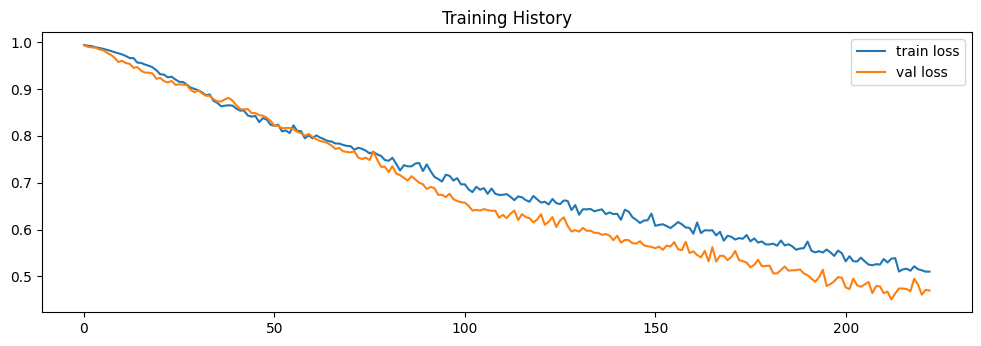

In [7]:
from core.viz import visualize_history

visualize_history(history, metrics=["loss"])

Even tough we didn't use a classic Siamese Network for training, we want our model architecture to be as close as possible to the Contrastive Loss model for better comparisons (with the exception of using cosine distance).

We'll have to train the final layer of our Siamese model, otherwise we'll just get random outputs. To do that we'll freeze the weights of the entire encoder.

In [8]:
from core.model import new_Siamese_Network
from core.distance import cosine_distance

snn_encoder.trainable = False

siamese_snn = new_Siamese_Network(
    encoder=snn_encoder,
    distance=cosine_distance
)
siamese_snn.summary()

Model: "SNN_6_siamese"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 21, 3)]              0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 21, 3)]              0         []                            
                                                                                                  
 SNN_6_encoder (Functional)  (None, 48)                   3532374   ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 lambda_1 (Lambda)           (None, 1)                    0         ['SNN_6_encoder[0]

In [9]:
pair_dataset = dataset.load_pairs(
    exclusive_test_labels=TEST_LABELS,
    margin=1
)

x_train_1 = pair_dataset.x_train_1
x_train_2 = pair_dataset.x_train_2
labels_train = pair_dataset.y_train

x_test_1 = pair_dataset.x_test_1
x_test_2 = pair_dataset.x_test_2
labels_test = pair_dataset.y_test

In [10]:
from core.loss import new_contrastive_loss

contrastive_loss = new_contrastive_loss(margin=1)

In [11]:
from keras.optimizers import Adam

# Use Adam optimizer
adam = Adam(learning_rate=0.0005, beta_2=0.99, epsilon=0.01)

# Compile model
siamese_snn.compile(
    loss=contrastive_loss,
    optimizer=adam,
    metrics=['acc']
)

In [12]:
# Reduce learning rate if no improvement is made (after 5 epochs)
# Use callback to stop training if no improvement is made (after 10 epochs)
reduce_lr, early_stop = new_default_callbacks(
    monitor="val_acc",
    mode="max"
)

In [13]:
# Training hyperparameters
epochs = 50
val_split = .2
batch_size=128

In [14]:
# Start training
history = siamese_snn.fit(
    [x_train_1, x_train_2], 
    labels_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=val_split,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
72/72 [==============================] - 2s 15ms/step - loss: 0.2193 - acc: 0.7775 - val_loss: 0.4998 - val_acc: 0.5002 - lr: 5.0000e-04
Epoch 2/50
72/72 [==============================] - 1s 13ms/step - loss: 0.2182 - acc: 0.7725 - val_loss: 0.4998 - val_acc: 0.5002 - lr: 5.0000e-04
Epoch 3/50
72/72 [==============================] - 1s 13ms/step - loss: 0.2175 - acc: 0.7695 - val_loss: 0.4998 - val_acc: 0.5002 - lr: 5.0000e-04
Epoch 4/50
72/72 [==============================] - 1s 15ms/step - loss: 0.2161 - acc: 0.7709 - val_loss: 0.4998 - val_acc: 0.5002 - lr: 5.0000e-04
Epoch 5/50
72/72 [==============================] - 1s 15ms/step - loss: 0.2151 - acc: 0.7694 - val_loss: 0.4998 - val_acc: 0.5002 - lr: 5.0000e-04
Epoch 6/50
68/72 [===========================>..] - ETA: 0s - loss: 0.2143 - acc: 0.7701
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
72/72 [==============================] - 1s 14ms/step - loss: 0.2140 - acc: 0.7694 - val_loss: 

As we would expect the single layer converges very quickly.

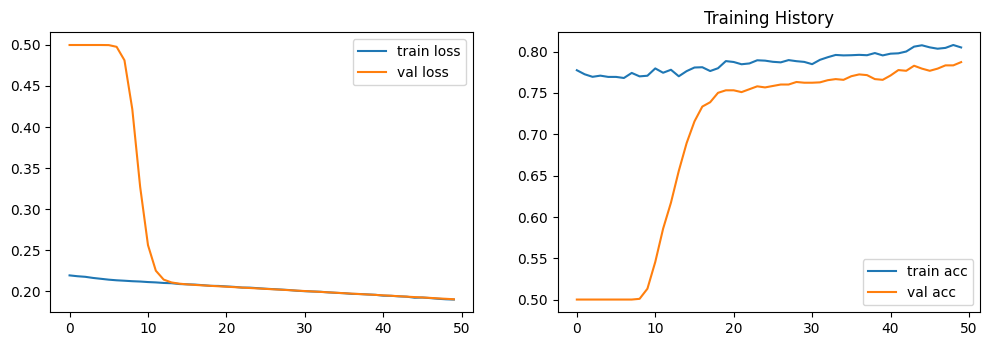

In [15]:
from core.viz import visualize_history

visualize_history(
    history,
    ["loss", "acc"]
)

Our accuracy on new signs however, seems significantly worse than with Contrastive Loss:

In [16]:
# And evaluate the model on test data
loss, acc = siamese_snn.evaluate([x_test_1, x_test_2], labels_test, verbose=0)
print(f'++++++++++++ Test data ++++++++++++\nloss={loss:.4f} acc={acc:.4f}')

++++++++++++ Test data ++++++++++++
loss=0.1672 acc=0.8129


Evaluating the model on the classification task shows the same trend:

In [17]:
from core.util import evaluate_classification

ITERATIONS = 50

y_true, y_pred, _, mean_acc = evaluate_classification(
    model=siamese_snn,
    x_test=x_test,
    y_test=y_test,
    iterations=ITERATIONS
)

print(f'++++++++++++ Mean accuracy (classification) over {ITERATIONS} iterations ++++++++++++\nacc={mean_acc:.4f}')

247/247 [==============================] - 1s 3ms/step
++++++++++++ Mean accuracy (classification) over 50 iterations ++++++++++++
acc=0.6949


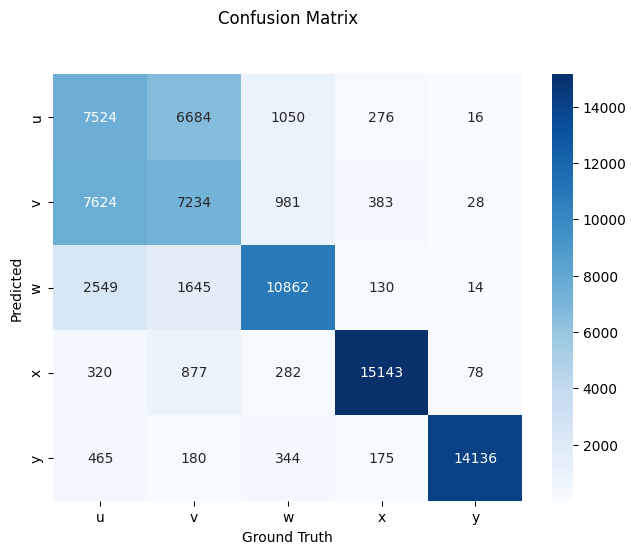

In [18]:
from core.viz import visualize_confusion_matrix

unique_test_labels = list(set(y_test))
reverse_label_map = {int_lbl: str_lbl for str_lbl, int_lbl in label_map.items()}
str_test_labels = [reverse_label_map[lbl] for lbl in unique_test_labels]

visualize_confusion_matrix(y_true, y_pred, str_test_labels)

In [19]:
# Get embeddings for the test data
embeddings = snn_encoder.predict(x_test)

50/50 [==============================] - 0s 3ms/step


In [20]:
from sklearn.manifold import TSNE

# Fit T-SNE on embeddings
tsne = TSNE(n_components=2, random_state=42, verbose=1)
reduced_embeddings = tsne.fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1585 samples in 0.000s...
[t-SNE] Computed neighbors for 1585 samples in 0.325s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1585
[t-SNE] Computed conditional probabilities for sample 1585 / 1585
[t-SNE] Mean sigma: 2.673034
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.528004
[t-SNE] KL divergence after 1000 iterations: 0.382208


Again, the confusion matrix is reflected in the model's embeddings:

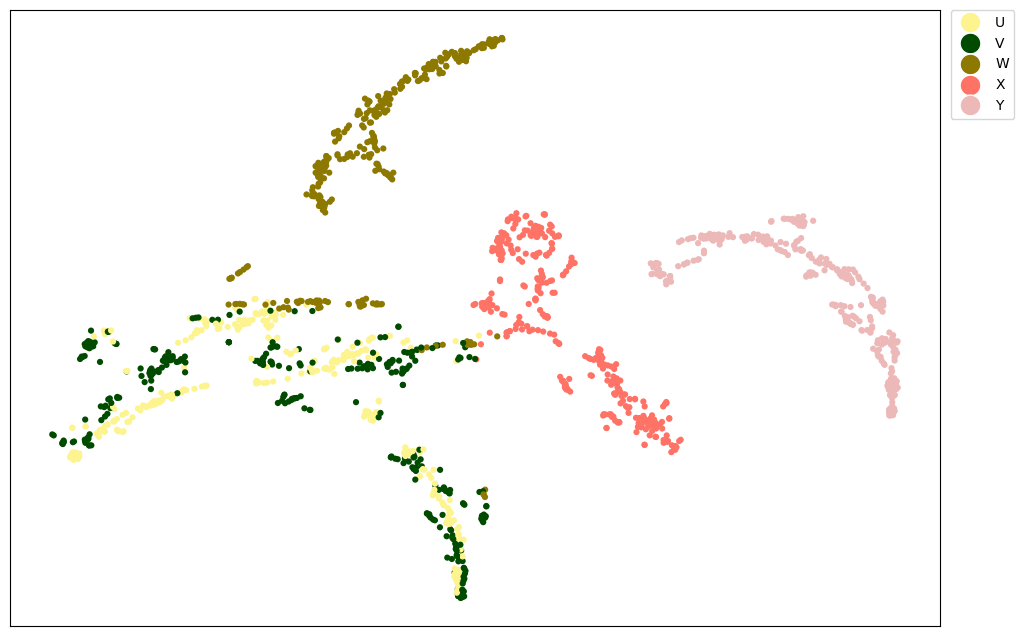

In [21]:
from core.viz import visualize_embeddings

# Visualize embeddings in scatter plot
visualize_embeddings(
    reduced_embeddings,
    y_test,
    label_map
)